<a href="https://colab.research.google.com/github/akhilp90/Game-Content-Optimization/blob/main/GameContentOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import pandas as pd

df = pd.read_csv("candy_crush_player_level_data.csv")


In [94]:
df.head()


,player_id,level_id,attempts,success,moves_used,time_spent_sec,used_booster,accuracy,first_attempt_success,num_retries,date_played,rage_quit,avg_time_per_attempt,num_obstacles,retry_gap_time,session_id,avg_moves_per_attempt
0,player_328,level_15,7,1,24.0,447.24,0,0.14,0,6,2025-06-16 02:50:07.157054,0,63.89,1,51.02,cc6d0ccd,3.43
1,player_13,level_95,8,1,49.0,433.60,0,0.12,0,7,2025-07-23 02:50:07.157526,0,54.20,3,281.87,37e84fc1,6.12
2,player_141,level_32,2,0,NaN,134.54,0,0.00,0,1,2025-07-03 02:50:07.157910,0,67.27,4,132.42,e9dd0806,NaN
3,player_115,level_18,1,1,37.0,585.04,0,1.00,1,0,2025-06-08 02:50:07.158340,0,585.04,5,63.90,5660cfe6,37.00
4,player_378,level_14,7,1,12.0,520.17,0,0.14,0,6,2025-07-16 02:50:07.158634,0,74.31,1,284.92,c96de964,1.71


In [64]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   player_id              10000 non-null  object 
 1   level_id               10000 non-null  object 
 2   attempts               10000 non-null  int64  
 3   success                10000 non-null  int64  
 4   moves_used             7050 non-null   float64
 5   time_spent_sec         10000 non-null  float64
 6   used_booster           10000 non-null  int64  
 7   accuracy               10000 non-null  float64
 8   first_attempt_success  10000 non-null  int64  
 9   num_retries            10000 non-null  int64  
 10  date_played            10000 non-null  object 
 11  rage_quit              10000 non-null  int64  
 12  avg_time_per_attempt   10000 non-null  float64
 13  num_obstacles          10000 non-null  int64  
 14  retry_gap_time         10000 non-null  float64
 15  ses

In [65]:
print(df.isnull().sum())


player_id                   0
level_id                    0
attempts                    0
success                     0
moves_used               2950
time_spent_sec              0
used_booster                0
accuracy                    0
first_attempt_success       0
num_retries                 0
date_played                 0
rage_quit                   0
avg_time_per_attempt        0
num_obstacles               0
retry_gap_time              0
session_id                  0
avg_moves_per_attempt    2950
dtype: int64


In [95]:
# Handle missing values
df["moves_used"] = df.apply(lambda row: row["moves_used"] if row["success"] == 1 else None, axis=1)

# Fill or drop if needed
df.dropna(subset=["attempts", "time_spent_sec"], inplace=True)


In [67]:
print(df.shape)


(10000, 17)


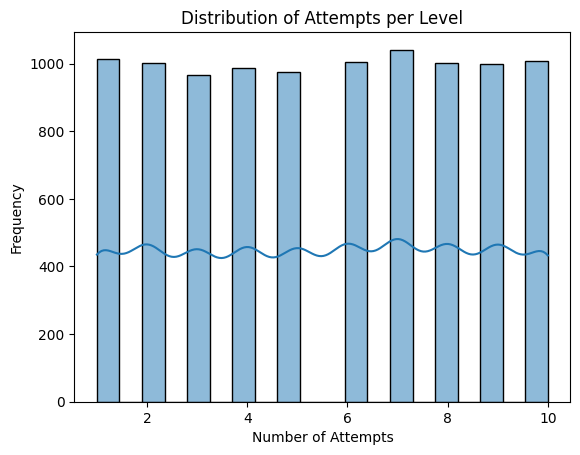

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['attempts'], bins=20, kde=True)
plt.title("Distribution of Attempts per Level")
plt.xlabel("Number of Attempts")
plt.ylabel("Frequency")
plt.show()


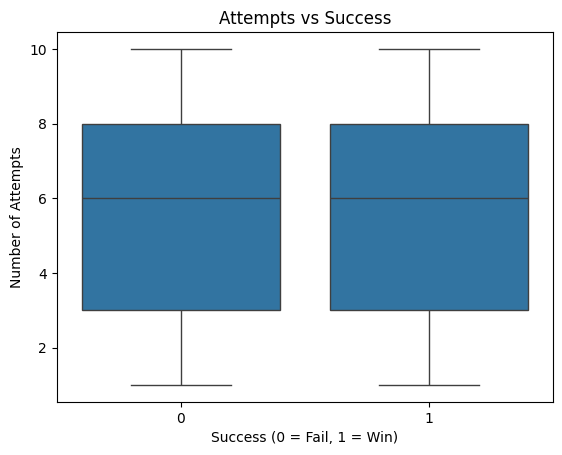

In [24]:
sns.boxplot(x='success', y='attempts', data=df)
plt.title("Attempts vs Success")
plt.xlabel("Success (0 = Fail, 1 = Win)")
plt.ylabel("Number of Attempts")
plt.show()


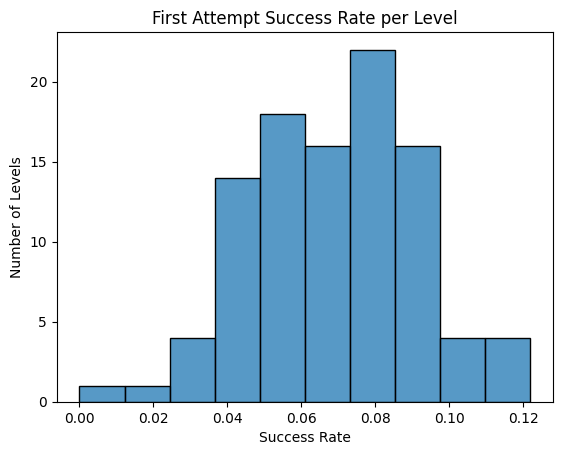

In [25]:
level_success_rate = df.groupby('level_id')['first_attempt_success'].mean().reset_index()
sns.histplot(level_success_rate['first_attempt_success'], bins=10)
plt.title("First Attempt Success Rate per Level")
plt.xlabel("Success Rate")
plt.ylabel("Number of Levels")
plt.show()


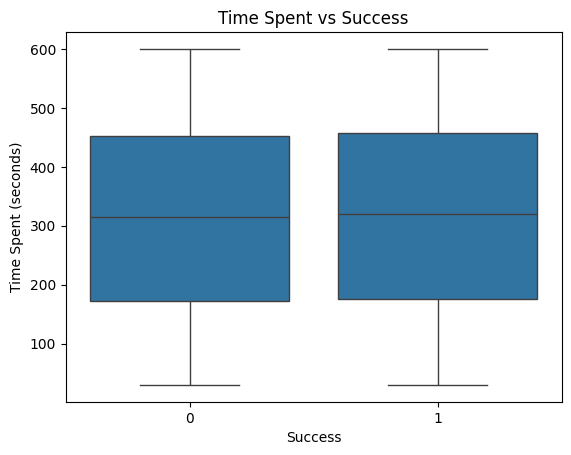

In [26]:
sns.boxplot(x='success', y='time_spent_sec', data=df)
plt.title("Time Spent vs Success")
plt.xlabel("Success")
plt.ylabel("Time Spent (seconds)")
plt.show()


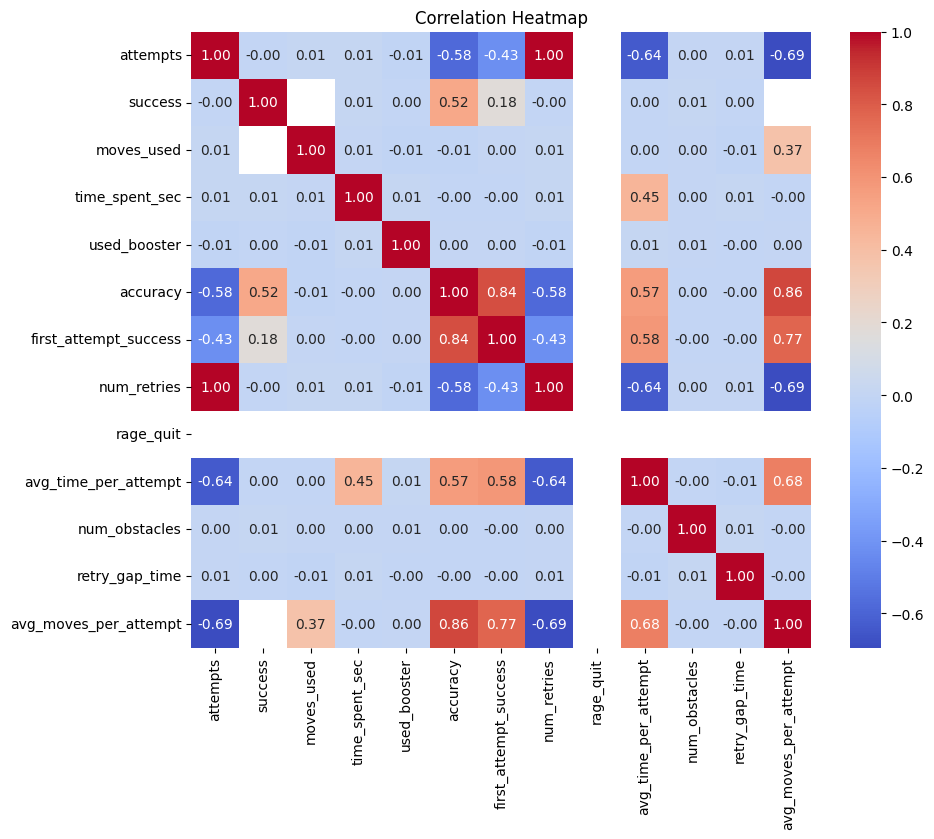

In [28]:
numeric_cols = df.select_dtypes(include='number')
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


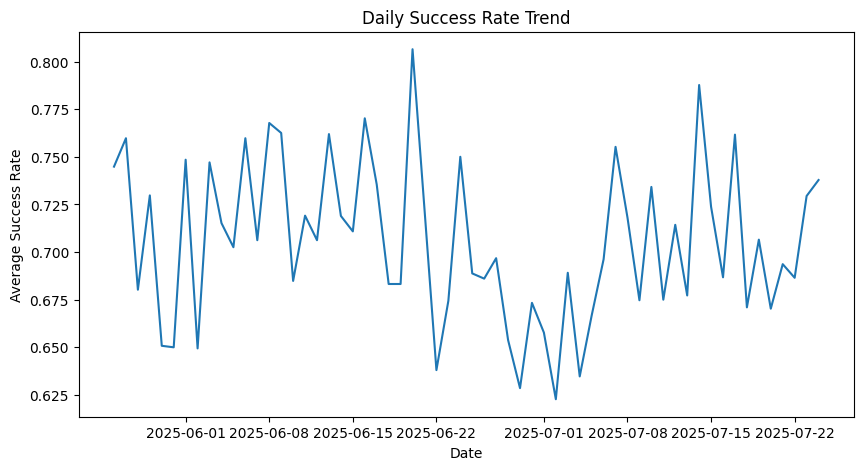

In [29]:
df['date_played'] = pd.to_datetime(df['date_played'])
daily_success = df.groupby(df['date_played'].dt.date)['success'].mean()

daily_success.plot(figsize=(10,5))
plt.title("Daily Success Rate Trend")
plt.xlabel("Date")
plt.ylabel("Average Success Rate")
plt.show()


Grouping Players into Beginner,Intermediate and Expert

In [96]:
level_stats = df.groupby("level_id").agg({
    "attempts": "mean",
    "success": "mean",
    "first_attempt_success": "mean",
    "time_spent_sec": "mean"
}).reset_index().rename(columns={
    "attempts": "avg_attempts",
    "success": "success_rate",
    "first_attempt_success": "first_try_rate",
    "time_spent_sec": "avg_time_spent"
})


In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = level_stats[["avg_attempts", "success_rate", "first_try_rate", "avg_time_spent"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
level_stats['difficulty_cluster'] = kmeans.fit_predict(X_scaled)


In [98]:
player_stats = df.groupby("player_id").agg({
    "attempts": "mean",
    "success": "mean",
    "first_attempt_success": "mean",
    "time_spent_sec": "mean"
}).reset_index()

player_stats.columns = ["player_id", "avg_attempts", "success_rate", "first_try_rate", "avg_time_spent"]


In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(player_stats[["avg_attempts", "success_rate", "first_try_rate", "avg_time_spent"]])

kmeans = KMeans(n_clusters=3, random_state=42)
player_stats["skill_cluster"] = kmeans.fit_predict(X_scaled)


In [100]:

cluster_means = player_stats.groupby("skill_cluster").mean(numeric_only=True)
cluster_to_label = {
    0: "Beginner",
    1: "Intermediate",
    2: "Expert"
}

player_stats["skill_level"] = player_stats["skill_cluster"].map(cluster_to_label)


In [101]:
player_skill_labels = player_stats[["player_id", "skill_level"]]
print(player_skill_labels.head())


    player_id skill_level
0    player_1      Expert
1   player_10      Expert
2  player_100      Expert
3  player_101      Expert
4  player_102      Expert


In [102]:
df = df.merge(player_skill_labels, on="player_id", how="left")


In [103]:
player_counts = df[["player_id", "skill_level"]].drop_duplicates()["skill_level"].value_counts()
print(player_counts)


skill_level
Expert          197
Intermediate    165
Beginner        138
Name: count, dtype: int64


Grouping Levels into easy,medium and difficult labels

In [104]:
level_stats = df.groupby("level_id").agg({
    "attempts": "mean",
    "time_spent_sec": "mean",
    "success": "mean",
    "moves_used": "mean",
    "rage_quit": "mean",
    "num_obstacles": "mean"
}).rename(columns={
    "attempts": "avg_attempts",
    "time_spent_sec": "avg_time_spent",
    "success": "success_rate",
    "moves_used": "avg_moves_used",
    "rage_quit": "rage_quit_rate"
}).reset_index()


In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X = scaler.fit_transform(level_stats.drop("level_id", axis=1))

kmeans = KMeans(n_clusters=3, random_state=42)
level_stats["difficulty"] = kmeans.fit_predict(X)


In [106]:
cluster_map = level_stats.groupby("difficulty")["avg_attempts"].mean().sort_values().reset_index()
difficulty_order = {row["difficulty"]: i for i, row in cluster_map.iterrows()}
level_stats["difficulty_label"] = level_stats["difficulty"].map(difficulty_order).map({0: "easy", 1: "medium", 2: "hard"})


In [107]:
level_stats.head()

,level_id,avg_attempts,avg_time_spent,success_rate,avg_moves_used,rage_quit_rate,num_obstacles,difficulty,difficulty_label
0,level_1,5.134146,309.258171,0.670732,32.981818,0.0,2.621951,1,medium
1,level_10,5.460000,307.051700,0.710000,33.535211,0.0,2.660000,1,medium
2,level_100,5.620253,315.413671,0.746835,29.881356,0.0,2.455696,0,hard
3,level_11,5.770642,328.156147,0.633028,29.942029,0.0,2.779817,2,easy
4,level_12,5.721649,320.933196,0.639175,31.500000,0.0,2.206186,1,medium


In [108]:
df = df.merge(level_stats[["level_id", "difficulty"]], on="level_id", how="left")


In [109]:
df.head()

,player_id,level_id,attempts,success,moves_used,time_spent_sec,used_booster,accuracy,first_attempt_success,num_retries,date_played,rage_quit,avg_time_per_attempt,num_obstacles,retry_gap_time,session_id,avg_moves_per_attempt,skill_level,difficulty
0,player_328,level_15,7,1,24.0,447.24,0,0.14,0,6,2025-06-16 02:50:07.157054,0,63.89,1,51.02,cc6d0ccd,3.43,Beginner,0
1,player_13,level_95,8,1,49.0,433.60,0,0.12,0,7,2025-07-23 02:50:07.157526,0,54.20,3,281.87,37e84fc1,6.12,Beginner,0
2,player_141,level_32,2,0,NaN,134.54,0,0.00,0,1,2025-07-03 02:50:07.157910,0,67.27,4,132.42,e9dd0806,NaN,Beginner,1
3,player_115,level_18,1,1,37.0,585.04,0,1.00,1,0,2025-06-08 02:50:07.158340,0,585.04,5,63.90,5660cfe6,37.00,Intermediate,1
4,player_378,level_14,7,1,12.0,520.17,0,0.14,0,6,2025-07-16 02:50:07.158634,0,74.31,1,284.92,c96de964,1.71,Expert,2


Using NCF Model to recommend ideal levels

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

player_encoder = LabelEncoder()
level_encoder = LabelEncoder()

df['player_encoded'] = player_encoder.fit_transform(df['player_id'])
df['level_encoded'] = level_encoder.fit_transform(df['level_id'])

num_players = df['player_encoded'].nunique()
num_levels = df['level_encoded'].nunique()

def label_engagement(row):
    if row['success'] == 1 and row['attempts'] == 1 and row['time_spent_sec'] < 30:
        return 0
    elif row['success'] == 0 and row['rage_quit'] == 1:
        return 2
    else:
        return 1

df['engagement_label'] = df.apply(label_engagement, axis=1)

class GameDataset(Dataset):
    def __init__(self, df):
        self.players = torch.tensor(df['player_encoded'].values, dtype=torch.long)
        self.levels = torch.tensor(df['level_encoded'].values, dtype=torch.long)
        self.labels = torch.tensor(df['engagement_label'].values, dtype=torch.long)

    def __len__(self):
        return len(self.players)

    def __getitem__(self, idx):
        return self.players[idx], self.levels[idx], self.labels[idx]

dataset = GameDataset(df)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

class NCFModel(nn.Module):
    def __init__(self, num_players, num_levels, embed_dim=32):
        super(NCFModel, self).__init__()
        self.player_embed = nn.Embedding(num_players, embed_dim)
        self.level_embed = nn.Embedding(num_levels, embed_dim)
        self.fc1 = nn.Linear(embed_dim * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 3)

    def forward(self, player, level):
        p = self.player_embed(player)
        l = self.level_embed(level)
        x = torch.cat([p, l], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

model = NCFModel(num_players, num_levels)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#model training
for epoch in range(5):
    total_loss = 0
    for player, level, label in dataloader:
        optimizer.zero_grad()
        preds = model(player, level)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

#simulating new user
new_user_play = pd.DataFrame({
    'level_id': ['level_1', 'level_3', 'level_7'],
    'success': [1, 0, 1],
    'attempts': [1, 3, 2],
    'rage_quit': [0, 0, 0],
    'time_spent_sec': [20, 100, 60]
})
new_user_play['level_encoded'] = level_encoder.transform(new_user_play['level_id'])
new_user_play['engagement_label'] = new_user_play.apply(label_engagement, axis=1)

skill_class = new_user_play['engagement_label'].mode()[0]
skill_map = {0: 'Beginner', 1: 'Intermediate', 2: 'Advanced'}
inferred_skill = skill_map[skill_class]
print("Inferred Skill Category:", inferred_skill)

player_embeddings = model.player_embed.weight.detach().numpy()
similar_user_ids = df[df['engagement_label'] == skill_class]['player_encoded'].unique()
user_embedding = player_embeddings[similar_user_ids].mean(axis=0)

with torch.no_grad():
    model.player_embed.weight[0] = torch.tensor(user_embedding)

level_torch = torch.tensor(np.arange(num_levels), dtype=torch.long)
dummy_player = torch.tensor([0] * num_levels, dtype=torch.long)

with torch.no_grad():
    preds = model(dummy_player, level_torch)
    probs = torch.softmax(preds, dim=1)
    just_right_scores = probs[:, 1]

top_k = torch.topk(just_right_scores, 5)
recommended_levels = level_encoder.inverse_transform(top_k.indices.numpy())
print("Top Recommended Levels for", inferred_skill, "user:", recommended_levels)

#Evaluating Recommendations

level_stats = df.groupby('level_encoded').agg({
    'time_spent_sec': 'mean',
    'success': 'mean',
    'attempts': 'mean',
}).reset_index()

def define_ideal(row, skill):
    if skill == 'Beginner':
        return row['success'] >= 0.7 and row['time_spent_sec'] <= 90
    elif skill == 'Intermediate':
        return row['success'] >= 0.6 and 60 <= row['time_spent_sec'] <= 150
    elif skill == 'Advanced':
        return row['success'] >= 0.5 and row['time_spent_sec'] > 120
    return False

level_stats['is_ideal'] = level_stats.apply(lambda row: define_ideal(row, inferred_skill), axis=1)
ideal_levels = set(level_stats[level_stats['is_ideal']]['level_encoded'])

recommended_level_encs = set(top_k.indices.numpy())
num_ideal = len(recommended_level_encs & ideal_levels)

precision = num_ideal / len(recommended_level_encs)
coverage = num_ideal / len(ideal_levels) if ideal_levels else 0

print(f"Ideal Match Precision: {precision:.2f}")
print(f"Ideal Coverage: {coverage:.2f}")


Epoch 1, Loss: 16.1291
Epoch 2, Loss: 3.6519
Epoch 3, Loss: 0.3948
Epoch 4, Loss: 0.1223
Epoch 5, Loss: 0.0734
Inferred Skill Category: Intermediate
Top Recommended Levels for Intermediate user: ['level_83' 'level_33' 'level_4' 'level_44' 'level_36']
Ideal Match Precision: 0.00
Ideal Coverage: 0.00


Episode 1/500 - Reward: 90.65 - Epsilon: 1.0000
Episode 2/500 - Reward: 76.20 - Epsilon: 1.0000
Episode 3/500 - Reward: 126.39 - Epsilon: 1.0000
Episode 4/500 - Reward: 88.21 - Epsilon: 0.9980
Episode 5/500 - Reward: 72.44 - Epsilon: 0.9960
Episode 6/500 - Reward: 82.84 - Epsilon: 0.9940
Episode 7/500 - Reward: 127.94 - Epsilon: 0.9920
Episode 8/500 - Reward: 91.19 - Epsilon: 0.9900
Episode 9/500 - Reward: 86.41 - Epsilon: 0.9881
Episode 10/500 - Reward: 83.05 - Epsilon: 0.9861
Episode 11/500 - Reward: 106.03 - Epsilon: 0.9841
Episode 12/500 - Reward: 99.73 - Epsilon: 0.9821
Episode 13/500 - Reward: 101.38 - Epsilon: 0.9802
Episode 14/500 - Reward: 106.36 - Epsilon: 0.9782
Episode 15/500 - Reward: 73.12 - Epsilon: 0.9763
Episode 16/500 - Reward: 68.83 - Epsilon: 0.9743
Episode 17/500 - Reward: 70.44 - Epsilon: 0.9724
Episode 18/500 - Reward: 98.92 - Epsilon: 0.9704
Episode 19/500 - Reward: 63.07 - Epsilon: 0.9685
Episode 20/500 - Reward: 66.90 - Epsilon: 0.9665
Episode 21/500 - Reward:

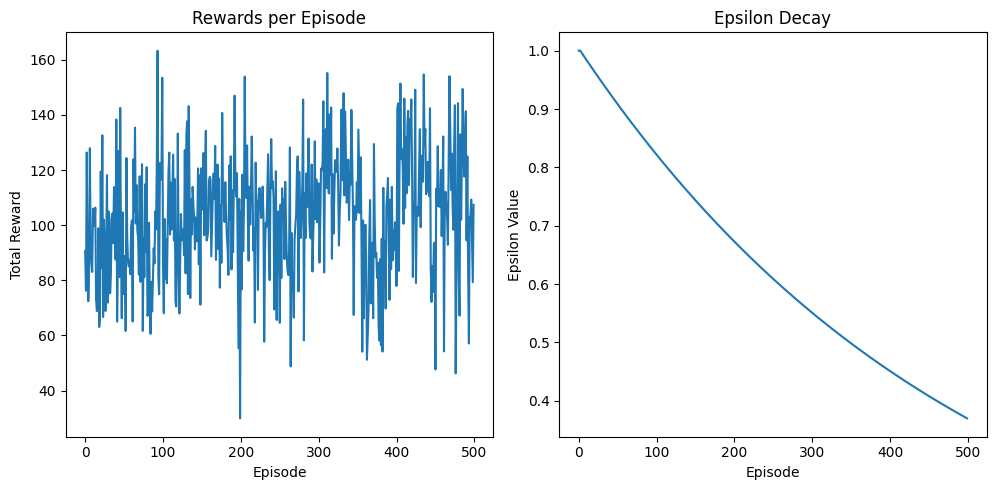

In [128]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt


class CandyCrushEnv:
    def __init__(self, num_levels):
        self.num_levels = num_levels
        self.player_skill = 0.5  # Track player skill progression

    def reset(self):
        self.player_skill = max(0.3, min(0.9, self.player_skill + random.uniform(-0.05, 0.05)))
        return np.array([
            self.player_skill,
            5,
            0,
            0.5,
            0,
            60,
            1,
            0
        ], dtype=np.float32)

    def step(self, action):
        level_difficulty = (action % 10) + 1
        skill_diff_ratio = self.player_skill / (level_difficulty * 0.15)
        win_prob = 1 / (1 + np.exp(-skill_diff_ratio))
        win_prob = max(0.05, min(0.95, win_prob))

        level_completed = random.random() < win_prob
        stars_earned = random.randint(1, 3) if level_completed else 0
        boosters_used = random.randint(0, 2) if not level_completed else random.randint(0, 1)
        num_retries = random.randint(1, 3) if not level_completed else 1
        avg_time = random.randint(30, 90)

        reward = (
            3 * stars_earned +
            2 * int(level_completed) -
            0.7 * num_retries -
            0.5 * boosters_used -
            0.1 * (avg_time / 60)
        )

        # Update player skill based on performance
        skill_delta = 0.02 if level_completed else -0.01
        self.player_skill = max(0.3, min(0.9, self.player_skill + skill_delta))

        next_state = np.array([
            self.player_skill,
            level_difficulty,
            boosters_used,
            win_prob,
            num_retries,
            avg_time,
            stars_earned,
            action / self.num_levels
        ], dtype=np.float32)

        done = False
        return next_state, reward, done, {}


# Enhanced DQN Network
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)


        if x.shape[0] > 1:
            x = self.relu(self.bn1(self.fc1(x)))
        else:
            x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.998
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005, weight_decay=1e-5)
        self.loss_fn = nn.SmoothL1Loss()
        self.batch_size = 64

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        self.model.eval()
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state)
            if len(state_tensor.shape) == 1:
                state_tensor = state_tensor.unsqueeze(0)
            act_values = self.model(state_tensor)
        self.model.train()
        return torch.argmax(act_values[0]).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor(np.array([t[0] for t in minibatch]))
        actions = torch.LongTensor(np.array([t[1] for t in minibatch]))
        rewards = torch.FloatTensor(np.array([t[2] for t in minibatch]))
        next_states = torch.FloatTensor(np.array([t[3] for t in minibatch]))
        dones = torch.FloatTensor(np.array([t[4] for t in minibatch]))

        # Double DQN implementation
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1))
        next_actions = self.model(next_states).max(1)[1].unsqueeze(1)
        next_q_values = self.target_model(next_states).gather(1, next_actions)
        targets = rewards.unsqueeze(1) + self.gamma * next_q_values * (1 - dones.unsqueeze(1))

        loss = self.loss_fn(current_q_values, targets.detach())

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

if __name__ == "__main__":
    env = CandyCrushEnv(num_levels=50)
    state_size = 8
    action_size = 50
    agent = Agent(state_size, action_size)
    episodes = 500
    update_target_freq = 10

    rewards_history = []
    epsilons_history = []
    losses_history = []

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        episode_loss = 0
        step_count = 0

        for time_t in range(20):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            if done:
                break

        agent.replay()

        if e % update_target_freq == 0:
            agent.update_target_model()

        rewards_history.append(total_reward)
        epsilons_history.append(agent.epsilon)

        print(f"Episode {e+1}/{episodes} - Reward: {total_reward:.2f} - Epsilon: {agent.epsilon:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(rewards_history)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(1, 3, 2)
    plt.plot(epsilons_history)
    plt.title('Epsilon Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')



    plt.tight_layout()
    plt.show()